In [3]:
import os
import tensorflow as tf

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = "D:\\Other\\datasets\\inception_v3_weights_tf.h5"
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy')>0.999:
            print("Reached 99.9% acc, toodles!")
            self.model.stop_training = True

In [8]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, Model
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation=tf.nn.relu)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation=tf.nn.sigmoid)(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [11]:
from gdown import download
download(id='1onaG42NZft3wCE1WH0GDEbUhu75fedP5', output='D:\\Other\\datasets\\')
download(id='1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U', output='D:\\Other\\datasets\\')

Downloading...
From: https://drive.google.com/uc?id=1onaG42NZft3wCE1WH0GDEbUhu75fedP5
To: D:\Other\datasets\horse-or-human.zip
100%|██████████| 150M/150M [00:22<00:00, 6.65MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1LYeusSEIiZQpwN-mthh5nKdA75VsKG1U
To: D:\Other\datasets\validation-horse-or-human.zip
100%|██████████| 11.5M/11.5M [00:01<00:00, 7.90MB/s]


'D:\\Other\\datasets\\validation-horse-or-human.zip'

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

local_zip = 'D:\\Other\\datasets\\horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
os.mkdir('D:\\Other\\datasets\\horse_human')
zip_ref.extractall('D:\\Other\\datasets\\horse_human\\training')
zip_ref.close()


In [14]:
train_horse_dir = 'D:\\Other\\datasets\\horse_human\\training\\horses'
train_human_dir = 'D:\\Other\\datasets\\horse_human\\training\\humans'

validation_horse_dir = 'D:\\Other\\datasets\\horse_human\\validation\\horses'
validation_human_dir = 'D:\\Other\\datasets\\horse_human\\validation\\humans'

train_horse_fnames = os.listdir(train_horse_dir)
train_human_fnames = os.listdir(train_human_dir)
validation_human_fnames = os.listdir(validation_human_dir)
validation_horse_fnames = os.listdir(validation_horse_dir)

print(len(train_horse_fnames))
print(len(train_human_fnames))
print(len(validation_human_fnames))
print(len(validation_horse_fnames))

500
527
128
128


In [15]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   shear_range=0.2)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    "D:\\Other\\datasets\\horse_human\\training",
    target_size=(150,150),
    class_mode='binary',
    batch_size=20,
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    "D:\\Other\\datasets\\horse_human\\validation",
    target_size=(150,150),
    class_mode='binary',
    batch_size=20,
    shuffle=True)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [16]:
callbacks = [myCallback()]
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=5,
                    callbacks=callbacks,
                    verbose=2)

Epoch 1/5
52/52 - 33s - loss: 0.0790 - accuracy: 0.9630 - val_loss: 0.0180 - val_accuracy: 0.9883
Epoch 2/5
52/52 - 12s - loss: 0.0096 - accuracy: 0.9961 - val_loss: 0.0109 - val_accuracy: 0.9961
Epoch 3/5
52/52 - 12s - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.0289 - val_accuracy: 0.9883
Epoch 4/5
52/52 - 13s - loss: 2.2368e-04 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 0.9922
Reached 99.9% acc, toodles!


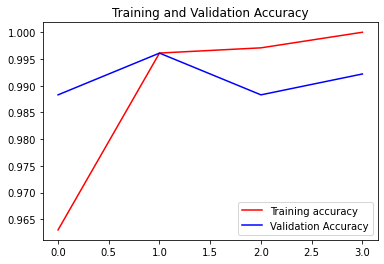

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

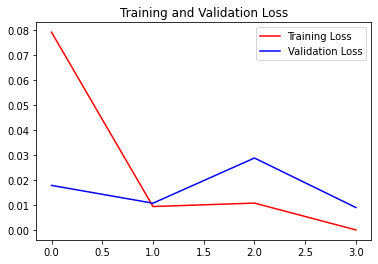

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend(loc=1)
plt.figure()
plt.show()